# Banking Fraud Detection with Temporian and TensorFlow Decision Forests

## Install and import dependencies


In [1]:
%pip install temporian -q

# Optional package used by Temporian to create interactive plots.
# If if Bokeh is not installed, Temporian plots are static.
%pip install bokeh -q

# To analyse the results
%pip install seaborn -q

# To train a model
%pip install tensorflow tensorflow_decision_forests -q

# To plot the ROC curve
%pip install scikit-learn -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pandas as pd
import temporian as tp
import datetime
import concurrent.futures
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_decision_forests as tfdf
from sklearn import metrics as sk_metrics

2023-07-05 20:04:53.187617: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-05 20:04:53.225210: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-05 20:04:53.226758: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 20:04:53.987201: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [34]:
start_date = datetime.date(2018, 4, 1)

#end_date = datetime.date(2018, 5, 31)
#train_test_split = datetime.date(2018,4,5)

end_date = datetime.date(2018, 9, 30)
train_test_split = datetime.datetime(2018, 9, 1) # TODO: Add support for datetime.date

filenames = []
while start_date <= end_date:
    filenames.append(f"{start_date}")
    start_date += datetime.timedelta(days=1)
print(f"{len(filenames)} dates")

183 dates


In [4]:
def load_date(filename):
    print(".",end="", flush=True)
    return pd.read_pickle(f"https://github.com/Fraud-Detection-Handbook/simulated-data-raw/raw/main/data/{filename}.pkl")

print("Loading dataset",end="")
with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
    frames = executor.map(load_date, filenames)
dataset_pd = pd.concat(frames)
print("done")
print(f"Found {len(dataset_pd)} transactions")

dataset_pd

Loading dataset.......................................................................................................................................................................................done
Found 1754155 transactions


,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0
...,...,...,...,...,...,...,...,...,...
1754150,1754150,2018-09-30 23:56:36,161,655,54.24,15810996,182,0,0
1754151,1754151,2018-09-30 23:57:38,4342,6181,1.23,15811058,182,0,0
1754152,1754152,2018-09-30 23:58:21,618,1502,6.62,15811101,182,0,0
1754153,1754153,2018-09-30 23:59:52,4056,3067,55.40,15811192,182,0,0


In [5]:
dataset_pd = dataset_pd[["TX_DATETIME", "CUSTOMER_ID", "TERMINAL_ID", "TX_AMOUNT", "TX_FRAUD"]]

In [46]:
dataset_tp = tp.from_pandas(dataset_pd, timestamps="TX_DATETIME")

dataset_tp

indexes: []
features: [('CUSTOMER_ID', str_), ('TERMINAL_ID', str_), ('TX_AMOUNT', float64), ('TX_FRAUD', int64)]
events:
     (1754155 events):
        timestamps: [1.5225e+09 1.5225e+09 1.5225e+09 ... 1.5384e+09 1.5384e+09 1.5384e+09]
        'CUSTOMER_ID': ['596' '4961' '2' ... '618' '4056' '3542']
        'TERMINAL_ID': ['3156' '3412' '1365' ... '1502' '3067' '9849']
        'TX_AMOUNT': [ 57.16  81.51 146.   ...   6.62  55.4   23.59]
        'TX_FRAUD': [0 0 0 ... 0 0 0]
memory usage: 98.2 MB

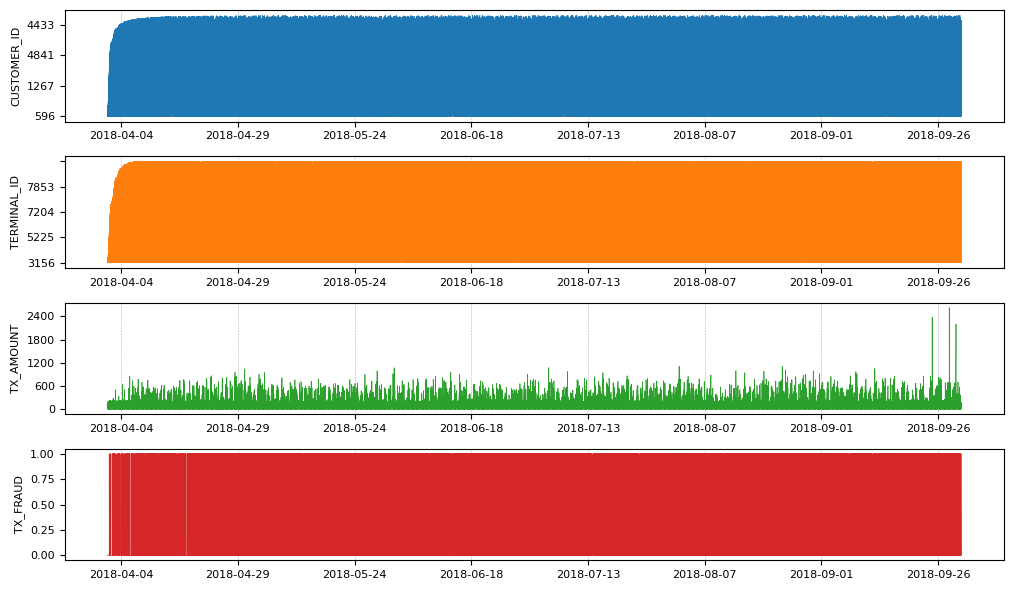

In [47]:
dataset_tp.plot()

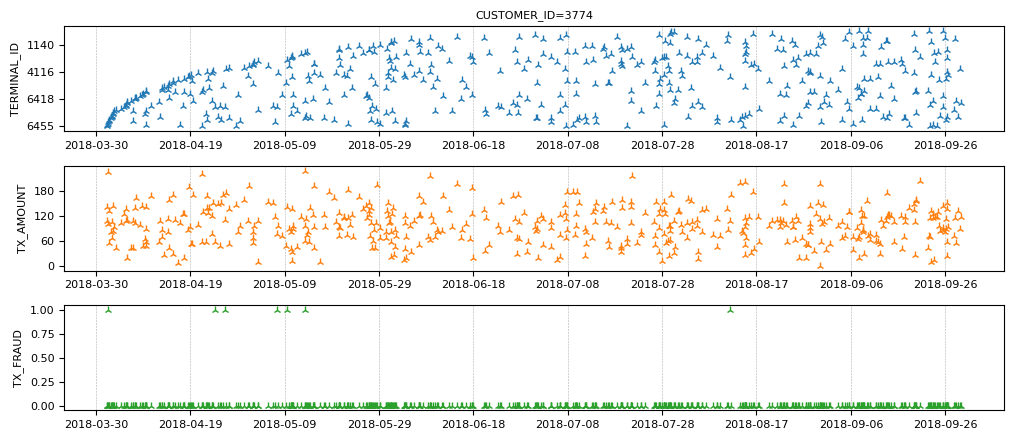

In [48]:
tp.add_index(dataset_tp, "CUSTOMER_ID").plot(indexes="3774")

# Same plot as:
# tp.filter(dataset_tp, tp.equal(dataset_tp["CUSTOMER_ID"], "3774")).plot()

In [65]:
@tp.compile
def augment_transactions(transactions: tp.EventSetNode) -> tp.EventSetNode:
    """Feature augmentation.
    
    Note: You can also remove @tp.compile and have the following header:
    augment_transactions(transactions: tp.EventSet) -> tp.EventSet
    The result will be the same, but the computation will take more memory
    and will potentially be slower.
    """

    transaction_id = tp.rename(tp.enumerate(transactions), "transaction_id")
    transactions = tp.glue(transactions, transaction_id)
    #print("\ntransactions:\n",transactions)

    per_terminal = tp.add_index(transactions, "TERMINAL_ID")
    lagged_fraud_per_terminal = tp.lag(per_terminal["TX_FRAUD"], tp.duration.days(1))
    feature_per_terminal = tp.moving_sum(lagged_fraud_per_terminal, tp.duration.weeks(4), sampling=per_terminal)
    feature_per_terminal = tp.rename(feature_per_terminal, "per_terminal.moving_sum_frauds")
    feature_per_terminal = tp.glue(feature_per_terminal, per_terminal)
    #print("\nper_terminal:\n",per_terminal)
    
    per_customer = tp.add_index(transactions, "CUSTOMER_ID")
    lagged_fraud_per_customer = tp.lag(per_customer["TX_FRAUD"], tp.duration.days(1))
    feature_per_customer = tp.moving_sum(lagged_fraud_per_customer, tp.duration.weeks(4), sampling=per_customer)
    feature_per_customer = tp.rename(feature_per_customer, "per_customer.moving_sum_frauds")
    feature_per_customer = tp.glue(feature_per_customer, per_customer)
    #print("\nper_customer:\n",per_customer)

    augmented_transactions = tp.join(
        tp.drop_index(feature_per_terminal),
        tp.drop_index(feature_per_customer)[["per_customer.moving_sum_frauds","transaction_id"]],
        on="transaction_id")
    #print("\naugmented_transactions:\n",augmented_transactions)

    return augmented_transactions

augmented_dataset_tp = augment_transactions(dataset_tp)

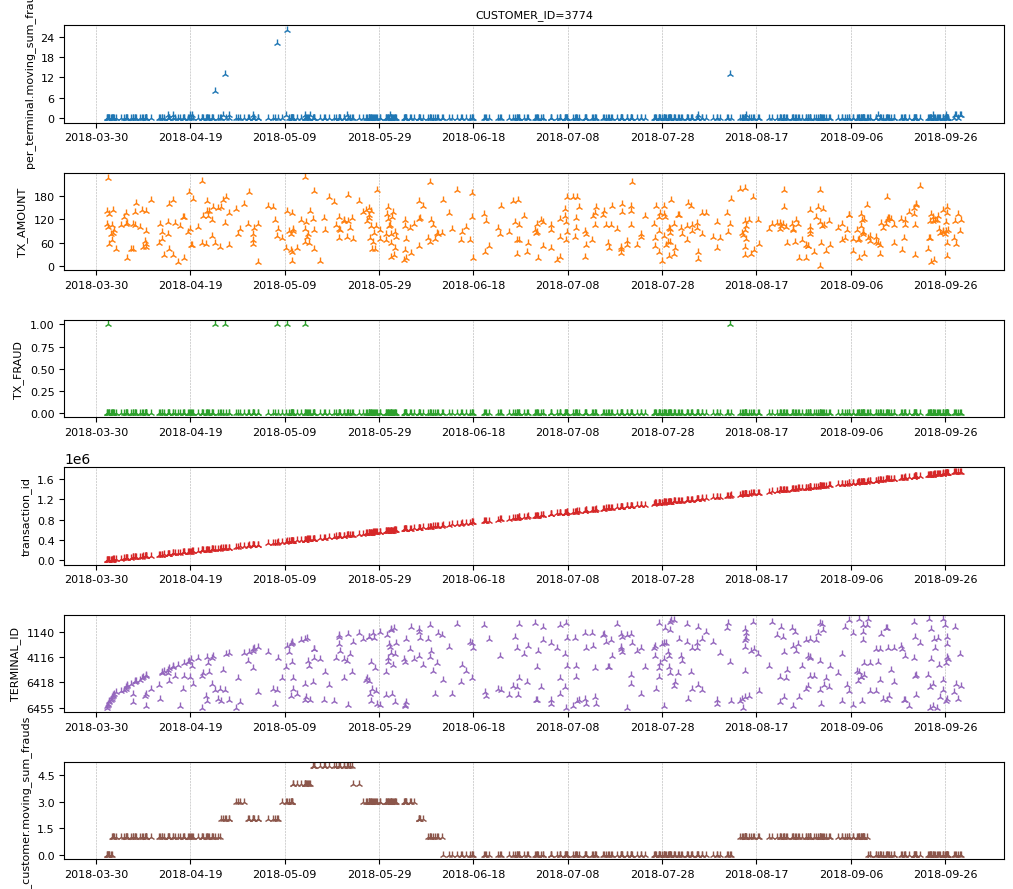

In [50]:
tp.add_index(augmented_dataset_tp, "CUSTOMER_ID").plot(indexes="3774")

In [68]:
tp.save(augment_transactions, inputs={"transactions":dataset_tp.schema}, path="/tmp/augment_transactions.tempo")

In [51]:
augmented_dataset_pd = tp.to_pandas(augmented_dataset_tp)

augmented_dataset_pd

,per_terminal.moving_sum_frauds,CUSTOMER_ID,TX_AMOUNT,TX_FRAUD,transaction_id,TERMINAL_ID,per_customer.moving_sum_frauds,timestamp
0,0,596,57.16,0,0,3156,0,1.522541e+09
1,0,4961,81.51,0,1,3412,0,1.522541e+09
2,0,2,146.00,0,2,1365,0,1.522541e+09
3,0,4128,64.49,0,3,8737,0,1.522541e+09
4,0,927,50.99,0,4,9906,0,1.522541e+09
...,...,...,...,...,...,...,...,...
1754150,0,161,54.24,0,1754150,655,0,1.538352e+09
1754151,0,4342,1.23,0,1754151,6181,0,1.538352e+09
1754152,0,618,6.62,0,1754152,1502,0,1.538352e+09
1754153,0,4056,55.40,0,1754153,3067,0,1.538352e+09


<Axes: xlabel='per_customer.moving_sum_frauds', ylabel='Proportion'>

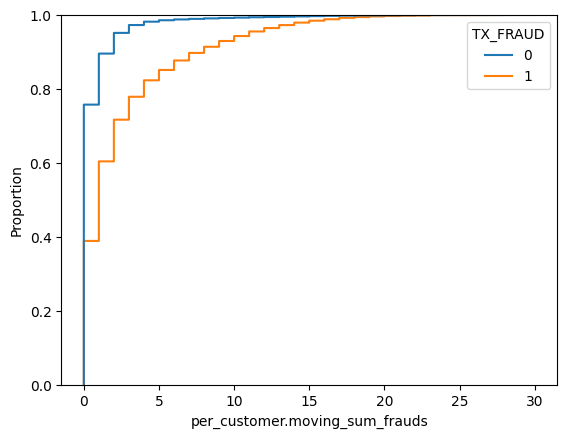

In [52]:
sns.ecdfplot(data=augmented_dataset_pd, x="per_customer.moving_sum_frauds", hue="TX_FRAUD")

<Axes: xlabel='per_terminal.moving_sum_frauds', ylabel='Proportion'>

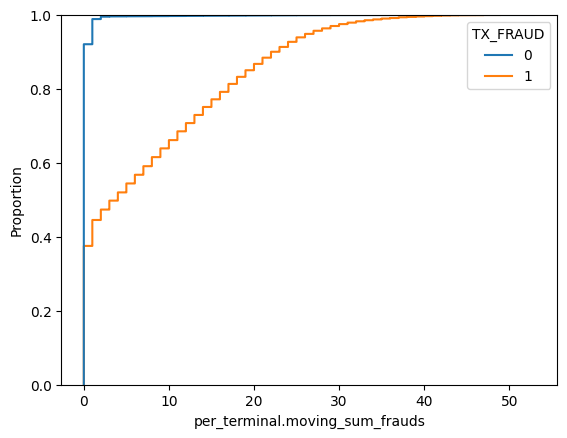

In [53]:
sns.ecdfplot(data=augmented_dataset_pd, x="per_terminal.moving_sum_frauds", hue="TX_FRAUD")

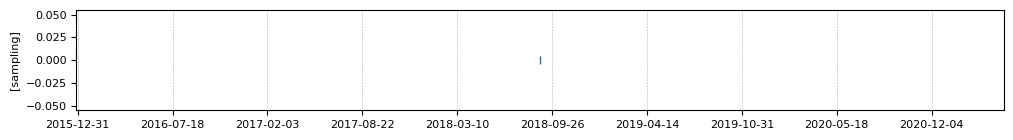

In [54]:
# Simplify when we have support for datetime.date
train_test_switch_tp = tp.event_set(timestamps=[train_test_split])

train_test_switch_tp.plot()

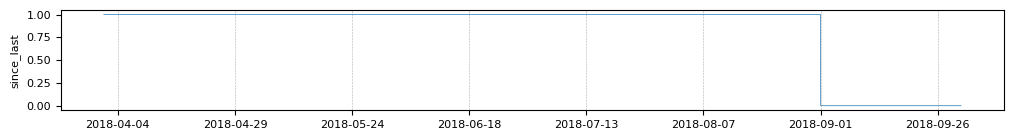

In [55]:
is_train = tp.isnan(tp.since_last(train_test_switch_tp, augmented_dataset_tp))
is_test = tp.invert(is_train)

is_train.plot()

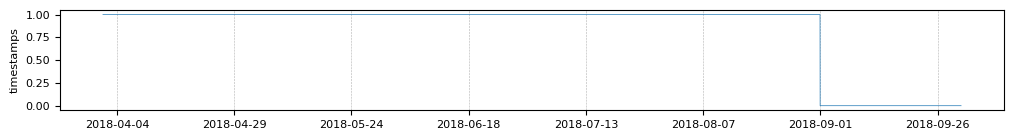

In [56]:
is_train = tp.timestamps(augmented_dataset_tp) < train_test_split.timestamp()
is_test = tp.invert(is_train)

is_train.plot()

In [57]:
augmented_dataset_train_tp = tp.filter(augmented_dataset_tp, is_train)
augmented_dataset_test_tp = tp.filter(augmented_dataset_tp, is_test)

In [58]:
augmented_dataset_train_tp.schema.features

[('per_terminal.moving_sum_frauds', int64),
 ('CUSTOMER_ID', str_),
 ('TX_AMOUNT', float64),
 ('TX_FRAUD', int64),
 ('transaction_id', int64),
 ('TERMINAL_ID', str_),
 ('per_customer.moving_sum_frauds', int64)]

In [59]:
dataset_train_pd = tp.to_pandas(augmented_dataset_train_tp)
dataset_test_pd = tp.to_pandas(augmented_dataset_test_tp)

print(f"Train example: {len(dataset_train_pd)}")
print(f"Test example: {len(dataset_test_pd)}")

dataset_train_tf = tfdf.keras.pd_dataframe_to_tf_dataset(dataset_train_pd, label="TX_FRAUD")
dataset_test_tf = tfdf.keras.pd_dataframe_to_tf_dataset(dataset_test_pd, label="TX_FRAUD")

Train example: 1466091
Test example: 288064


In [60]:
model = tfdf.keras.GradientBoostedTreesModel(features=[tfdf.keras.FeatureUsage("per_customer.moving_sum_frauds"),
                                                       tfdf.keras.FeatureUsage("per_terminal.moving_sum_frauds"),
                                                      ],
                                             exclude_non_specified_features=True)
model.fit(dataset_train_tf,verbose=1)

Use /tmp/tmp8sdc0fnd as temporary training directory
Reading training dataset...


[WARNING 23-07-05 20:20:05.8183 CEST gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-05 20:20:05.8183 CEST gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-05 20:20:05.8183 CEST gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-07-05 20:20:05.843522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1466091]
	 [[{{node Placeholder/_3}}]]


Training dataset read in 0:00:04.686483. Found 1466091 examples.
Training model...
Model trained in 0:00:31.022507
Compiling model...
Model compiled.


[INFO 23-07-05 20:20:41.5264 CEST kernel.cc:1242] Loading model from path /tmp/tmp8sdc0fnd/model/ with prefix 92d42703f96f4357
[INFO 23-07-05 20:20:41.5334 CEST abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-05 20:20:41.5334 CEST kernel.cc:1074] Use fast generic engine
2023-07-05 20:20:41.555040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1466091]
	 [[{{node Placeholder/_3}}]]


In [61]:
test_predictions = model.predict(dataset_test_tf)[:,0]

test_predictions

  1/289 [..............................] - ETA: 12s

2023-07-05 20:20:41.675303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [288064]
	 [[{{node Placeholder/_4}}]]


289/289 [==============================] - 1s 4ms/step


array([0.00146467, 0.00392959, 0.00357214, ..., 0.00146467, 0.00146467,
       0.00392959], dtype=float32)

In [62]:
test_labels = dataset_test_pd["TX_FRAUD"].values

test_labels

array([0, 0, 0, ..., 0, 0, 0])

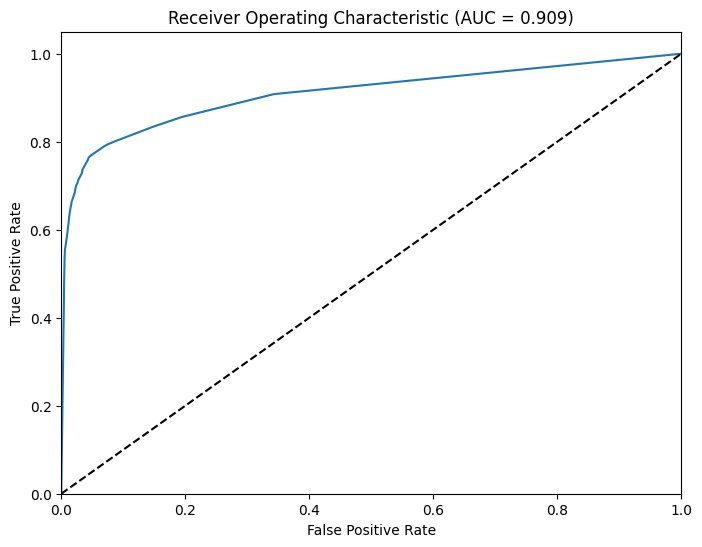

In [63]:
fpr, tpr, thresholds = sk_metrics.roc_curve(test_labels, test_predictions)
auc = sk_metrics.roc_auc_score(test_labels, test_predictions)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (AUC = %0.3f)'  % auc )
plt.show()